# Vehicle Detection and Tracking

In this project I am demonstrating computer vision techniques for vehicle detection and tracking.

In [1]:
# Importing required libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
import time
from scipy.ndimage.measurements import label
from queue import Queue

%matplotlib inline
print('Library import successful')

Library import successful


In [2]:
# extracting HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [5]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def remove_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [7]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [8]:
# Reading data

vehicle_images = glob.glob('data/vehicles/*/*.png')
non_vehicle_images = glob.glob('data/non-vehicles/*/*.png')

cars = []
notcars = []
for image in vehicle_images:
    cars.append(image)
    
for image in non_vehicle_images:
    notcars.append(image)
    
print('number of car samples: ', len(cars))
print('number of non-car samples: ', len(notcars))

number of car samples:  8792
number of non-car samples:  8968


In [9]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 16
cell_per_block = 4
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

### 1. Extract HOG features:

Here I am extracting HOG features from training using YCrCb color space, all color channels, 18 orientations, 16x16 pixels per cell and 4x4 cells per block. After Trying couple of color spaces and different values for orientations, pixels per cell and cells per block (e.g. YUV, 9 orientations, 8x8 pixels per cell and 2x2 cells per block), I settled on above set of parameters.

Hog features for car image


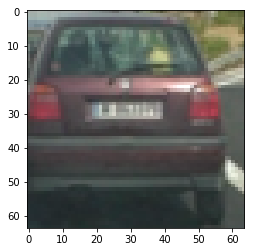

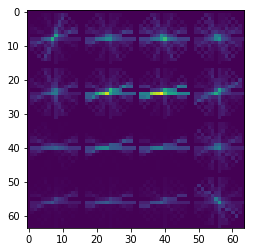

In [19]:
car = mpimg.imread(cars[34])

features, hog_image = get_hog_features(car[:,:,0] , orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(car)
plt.figure()
plt.imshow(hog_image)
plt.figure()
print('Hog features for car image')

Hog features for non-car image


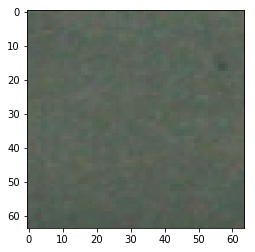

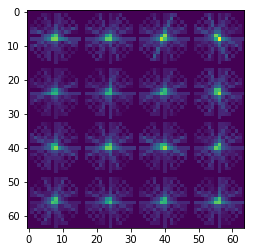

In [17]:
notcar = mpimg.imread(notcars[10])
features, hog_image = get_hog_features(notcar[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.imshow(notcar)
plt.figure()
plt.imshow(hog_image)
plt.figure()
print('Hog features for non-car image')

In [10]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

67.7 Seconds to extract HOG features...


In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### 2. Splitting data into train and test datasets

Once HOG features are extracted for all the data, I am mearging car and not-car data into single dataset and splitting it into 80% training data and 20% test data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
print(X_train.shape)
X_test = X_scaler.transform(X_test)
print(X_test.shape)

(14208, 864)
(3552, 864)


### 3. Training and Testing Model

Here I am using SVM Classifier with RBF Kernel and C=10. To get this particular parameters I ran SVM with Grid Search. The model is trained on training data and then test data is used to measure accuracy of model. Below I have shown predicted lables by model and actual labels. Once model is trained and tested and accuracy is satiesfactory. i have saved the model. 

In [13]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[10, 100]}
#parameters = {'C':[1, 100], 'gamma':[1, 100]}
#svc = LinearSVC()

#svr = svm.SVC(kernel = 'rbf', C = 10)
svc = svm.SVC(kernel = 'rbf', C = 10)
#svc = GridSearchCV(svr, parameters)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

18.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9913
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.
  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.]
For these 100 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.
  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.]


In [14]:
model = {}
model["classifier"]=svc
model["scaler"]=X_scaler
model["colorspace"]=colorspace
model["orient"]=orient
model["pix_per_cell"]=pix_per_cell
model["cell_per_block"]=cell_per_block
model["hog_channel"]=hog_channel
pickle.dump(model, open('model4.p', 'wb'))